# XY - Modell

In [42]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import json
from scipy.optimize import curve_fit
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (20, 6)

# Select most recent run

In [43]:
con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id']

# Energy

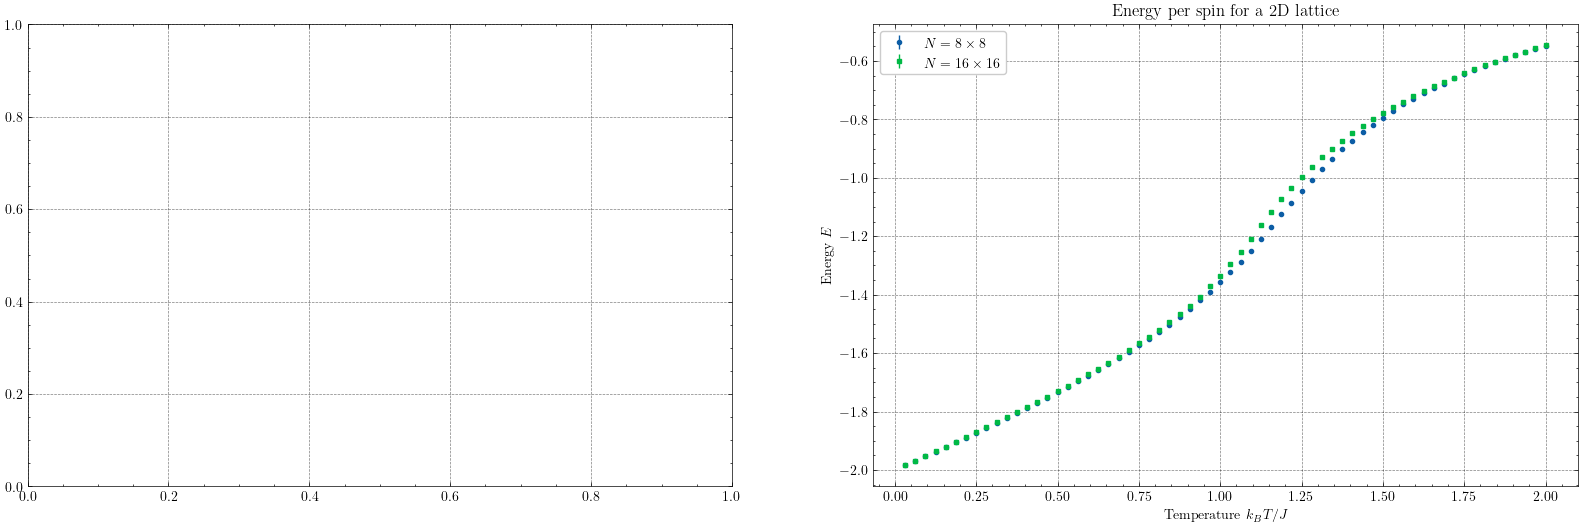

In [44]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['energy'], yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Energy per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Energy $E$')

    ax[name - 1].legend()

fig.savefig('figures/Energy.pdf', bbox_inches='tight')

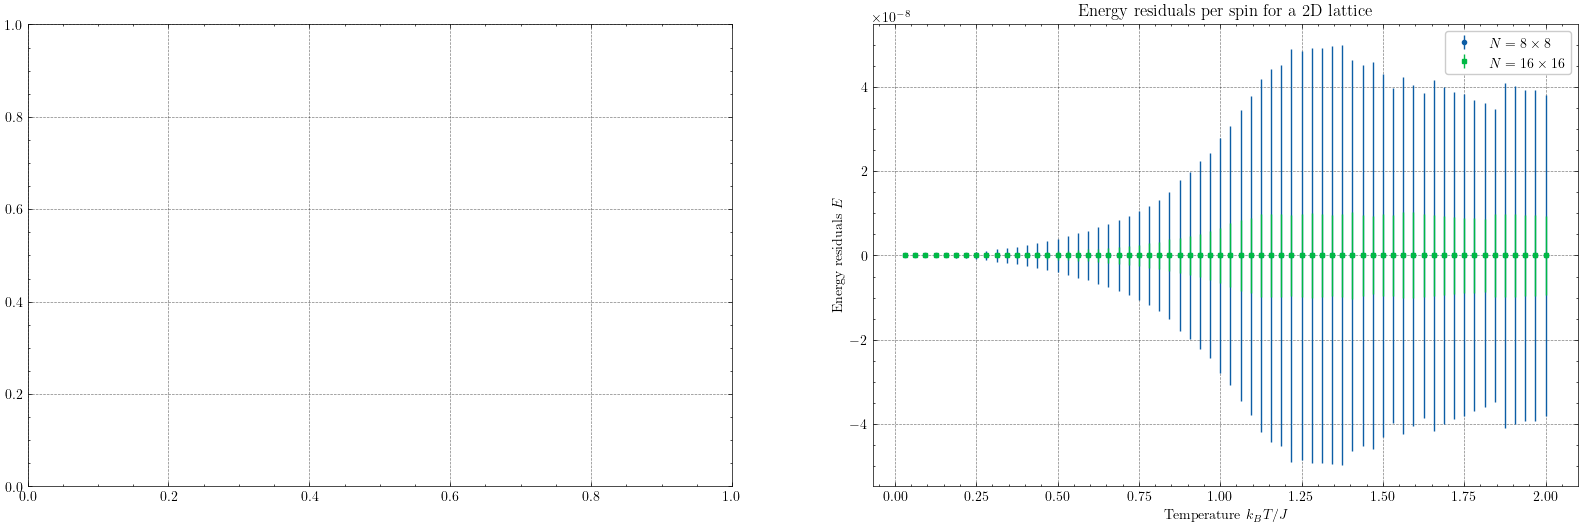

In [45]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], [0] * len(data['energy_std']), yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Energy residuals per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Energy residuals $E$')

    ax[name - 1].legend()

fig.savefig('figures/Energy_Residual.pdf', bbox_inches='tight')

# Magnetisation

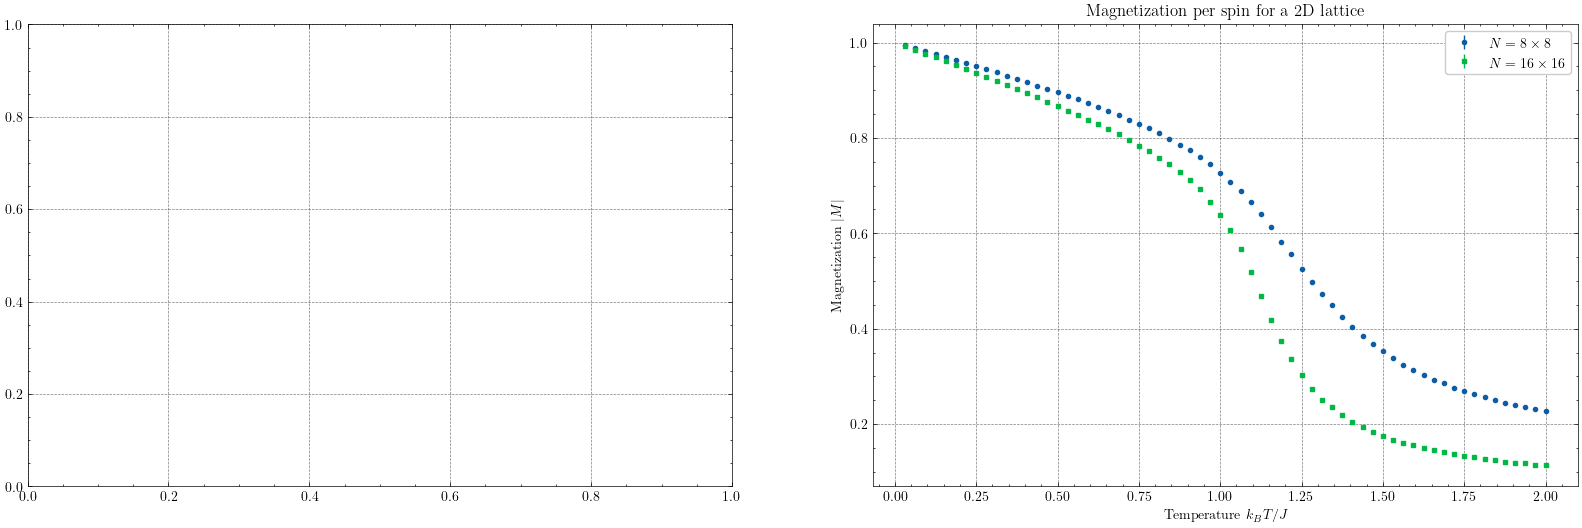

In [46]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['magnet'], yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Magnetization per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetization $\\lvert M \\rvert$')

    ax[name - 1].legend()

fig.savefig('figures/Magnetization.pdf', bbox_inches='tight')

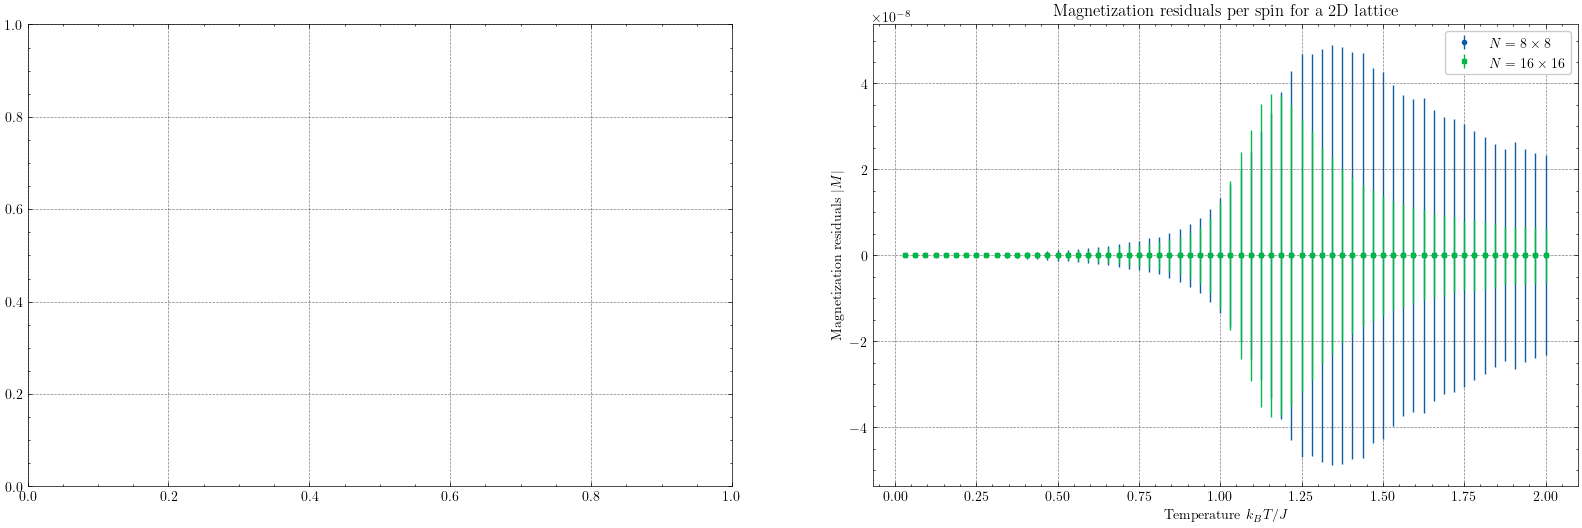

In [47]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], [0] * len(data['magnet_std']), yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Magnetization residuals per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetization residuals $\\lvert M \\rvert$')

    ax[name - 1].legend()

fig.savefig('figures/Magnetization_Residuals.pdf', bbox_inches='tight')

# Specific Heat

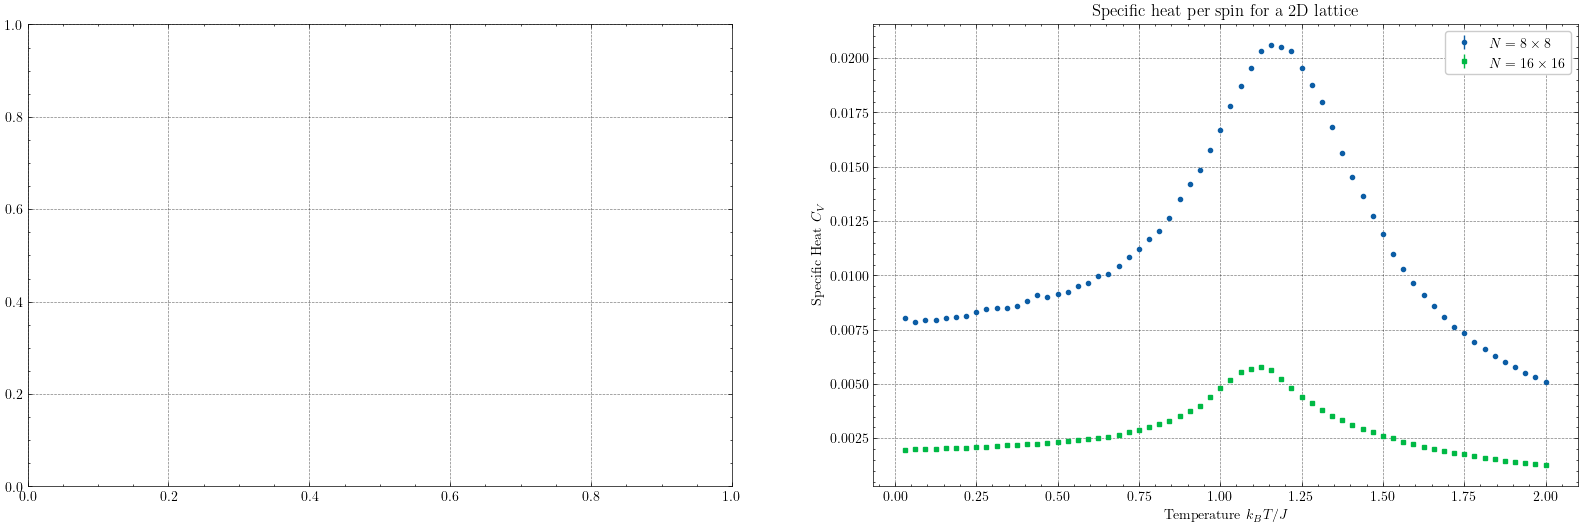

In [48]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, specific_heat, specific_heat_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['specific_heat'], yerr=data['specific_heat_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Specific heat per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Specific Heat $C_V$')

    #ax[name - 1].set_yscale('log')
    ax[name - 1].legend()

fig.savefig('figures/Specific_Heat.pdf', bbox_inches='tight')

# Magnetic susceptibility

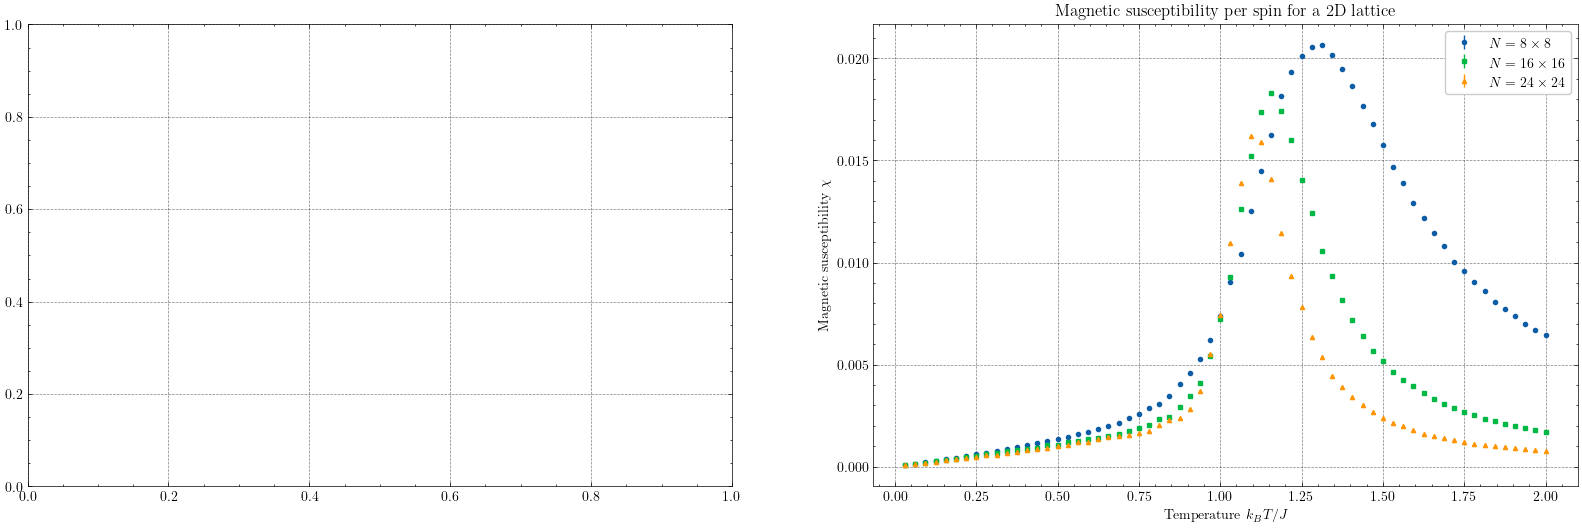

In [52]:
sizes = []
maximas = []
delta_maximas = []

fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet_suscept, magnet_suscept_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['magnet_suscept'], yerr=data['magnet_suscept_std'], label=f'$N = {size} \\times {size}$')

        if name == 2:
            max_idx = data['magnet_suscept'].idxmax()
            max_temp = data.loc[max_idx]['temperature']
            delta_max_temp = np.abs(data.loc[max_idx]['temperature'] - data.loc[max_idx + 1]['temperature'])

            sizes.append(1.0 / np.log(size)**2)
            maximas.append(max_temp)
            delta_maximas.append(delta_max_temp)

    ax[name - 1].set_title(f'Magnetic susceptibility per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetic susceptibility $\\chi$')

    #ax[name - 1].set_yscale('log')
    ax[name - 1].legend()

fig.savefig('figures/Magnetic_Susceptibility.pdf', bbox_inches='tight')

R Squared: 0.99704207


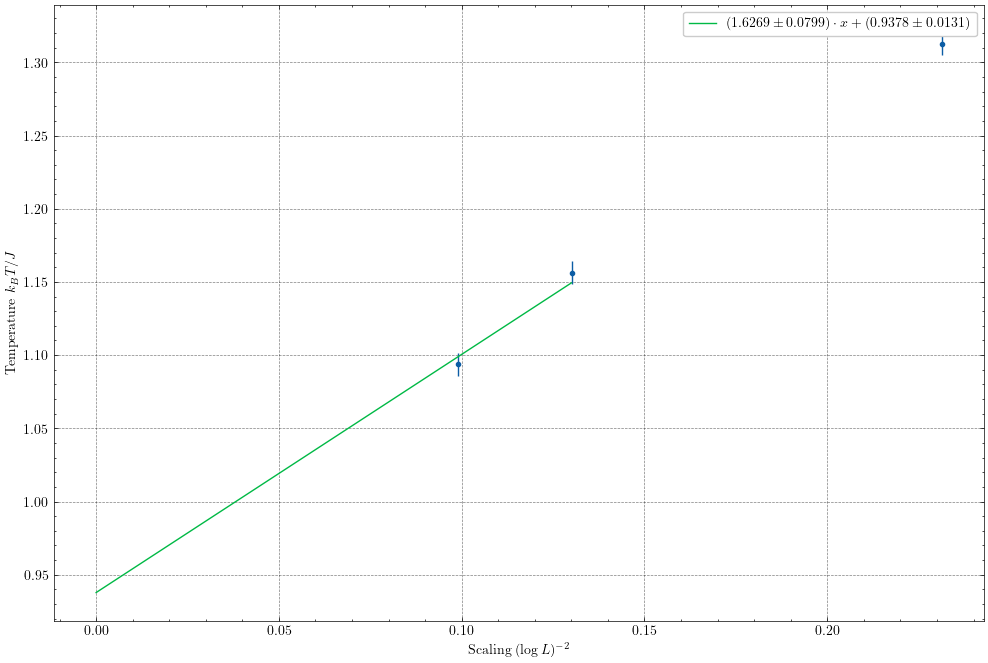

In [53]:
def linear_fn(x: float, slope: float, intercept: float) -> float:
    return slope * x + intercept

data = pd.read_sql_query(f'SELECT 1.0 / power(ln(r.size), 2) AS size, r.temperature FROM results AS r INNER JOIN (SELECT id, size, MAX(magnet_suscept) FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size) AS o ON (r.id = o.id)', con)

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data['size'], data['temperature'], yerr=[2.0 / 256] * len(data))

popt, pcov = curve_fit(linear_fn, data['size'], data['temperature'], sigma=[2.0 / 256] * len(data), absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

residuals = maximas - linear_fn(data['size'], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((maximas - np.mean(maximas))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R Squared: {r_squared:.8f}')

sampling = np.linspace(0, 0.13, num=100)
ax.plot(sampling, linear_fn(sampling, *popt), '-', label=f'$({popt[0]:.4f} \\pm {perr[0]:.4f}) \\cdot x + ({popt[1]:.4f} \\pm {perr[1]:.4f})$')

ax.set_xlabel('Scaling $(\\log{L})^{-2}$')
ax.set_ylabel('Temperature $k_B T / J$')

ax.legend()
fig.savefig('figures/Critical_Temperature.pdf', bbox_inches='tight')

# Vortex unbinding

In [51]:
size = 40

data = pd.read_sql_query(f'SELECT temperature, spins FROM results WHERE run_id = \'{current_run}\' AND size = {size} AND dimension = 2 ORDER BY temperature', con)
data = data[data.index % 8 == 0]

data['spins'] = data['spins'].apply(lambda x: np.array(json.loads(x)))
data['u'] = data['spins'].transform(lambda x: np.reshape(np.cos(x), (-1, size)))
data['v'] = data['spins'].transform(lambda x: np.reshape(np.sin(x), (-1, size)))

x = np.arange(1, size + 1, 1)
y = np.arange(1, size + 1, 1)

X, Y = np.meshgrid(x, y)

for idx, row in data.iterrows():
    fig, ax = plt.subplots()
    ax.set_box_aspect(1)

    ax.quiver(X, Y, row['u'], row['v'], row['spins'], scale=40, pivot='middle', cmap='hsv')
    ax.set_title(f'Temperature $T={row['temperature']:.3f}$')

    temperature = f'{row['temperature']:.3f}'.replace(".", "_")
    fig.savefig(f'figures/vortices/{temperature}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

DatabaseError: Execution failed on sql 'SELECT temperature, spins FROM results WHERE run_id = '1' AND size = 40 AND dimension = 2 ORDER BY temperature': no such column: spins

# Critical Slowing Down

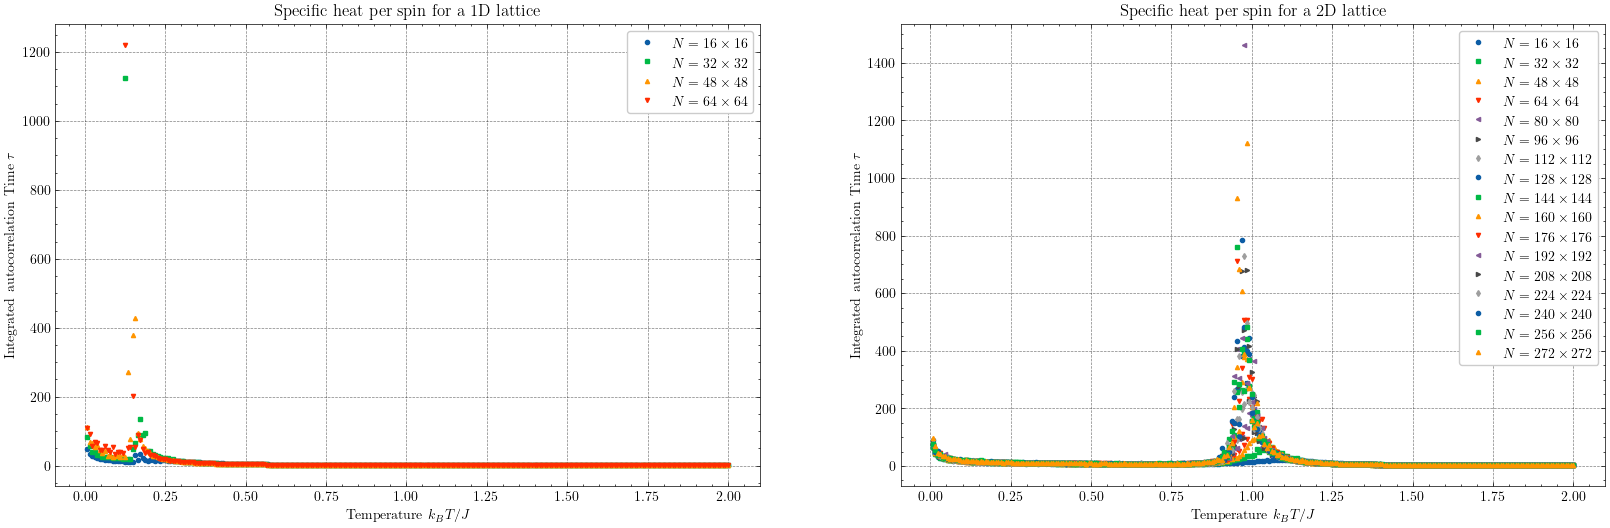

In [ ]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy_tau FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['energy_tau'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Specific heat per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Integrated autocorrelation Time $\\tau$')

    ax[name - 1].legend()

fig.savefig('figures/Critical_Slowing_Down.pdf', bbox_inches='tight')

# Scaling

11.503517281276702


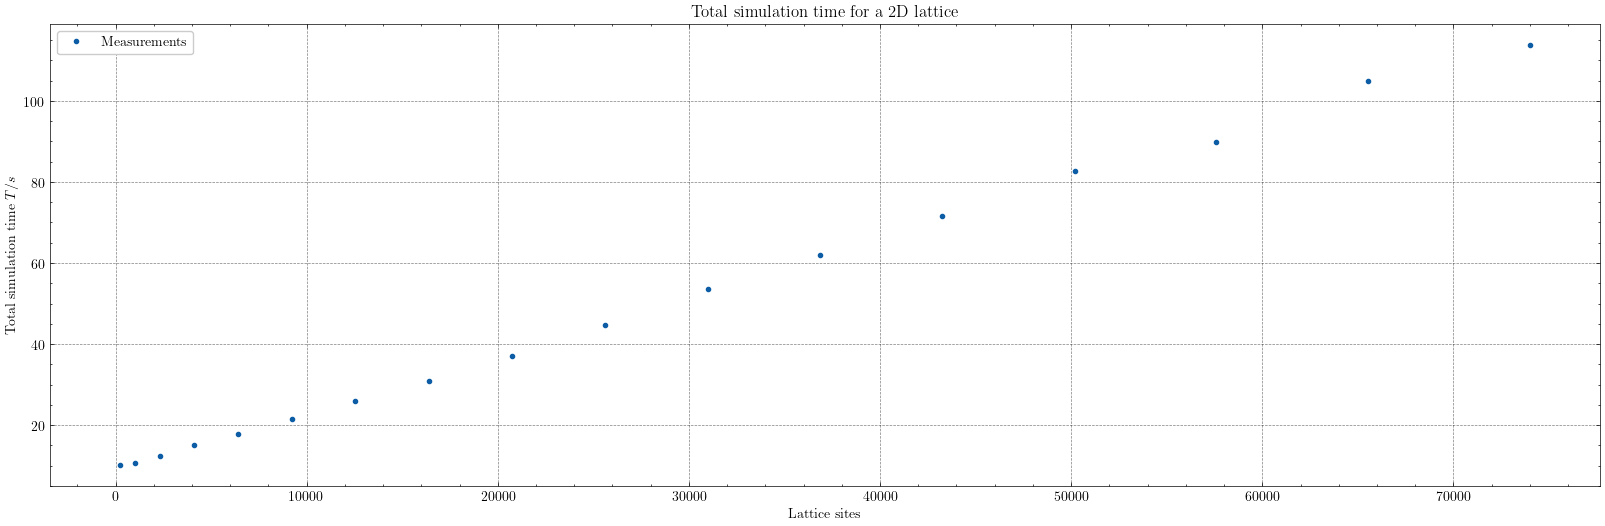

In [ ]:
data = pd.read_sql_query(f'SELECT size, dimension, MAX(time_mc + time_boot) AS total FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size', con)

fig, ax = plt.subplots()
ax.errorbar(data['size']**data['dimension'], data['total'] / (60 * 1000), label='Measurements')

popt, pcov = curve_fit(linear_fn, data['size']**data['dimension'], data['total'] / (60 * 1000))
perr = np.sqrt(np.diag(pcov))

#print(linear_fn(np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024])**2, *popt).sum() / 60)
print(linear_fn(np.arange(16, 256 + 1, 16)**2, *popt).sum() / 60)

ax.set_title(f'Total simulation time for a {name}D lattice')
ax.set_xlabel('Lattice sites')
ax.set_ylabel('Total simulation time $T / s$')

ax.legend()

fig.savefig('figures/Time_Scaling.pdf', bbox_inches='tight')